Using data from DC's 311 service request center and the US Census Bureau, I looked at how DC household income can relate to  service requests made in 2014. Specifically, I wanted to see if there was a relationship between average income and the frequency of 311 requests.

DC is divided in to eight Wards, and they all differ economically. I used data from the US Census Bureau's American Community Survey to find these differences regarding mean and median income. Although I looked at both mean and median household income, the median would be a more accurate measure, since the mean is likely to be skewed by outliers. I combined the income data with 311 request data provided from Open Data DC. This data is a record of all DC 311 calls made in 2014, and they are sorted into various categories. Some of these categories include trash collection, potholes, and parking issues. For this analysis, I narrowed down the categories to parking requests and non-parking requests. In addition, I cleaned this data by recoding the Ward column so each row only has the Ward number (eg. 1), and I fixed inconsistency errors in the service code description column.

To successfully answer my research question, I had to wrangle data between the 311 requests and Ward income data sets. At first, I tried merging, subsetting, then aggregating. I then realized I should merge last since I lost the income data as I aggregated. Thus, the final order that I used was subsetting, aggregating, then merging. I first subset the 311 request data into two additional data sets--one for parking requests, and one for non-parking requests. I then aggregated the data in both the parking data set and the non-parking data set to get the number of 311 requests for each Ward. Finally, I merged the 311 request data with the income data, so each Ward's median and mean incomes could be could be compared to the number of 311 requests made.

Upon visualizing the data, I concluded that income does affect the number of 311 parking requests made, but it does not affect non-parking requests. Disregarding Ward 3, the number of parking requests seem to increase as the median income increases. Non-parking requests do not follow the same pattern, since Ward 4 makes the most requests without having the highest median income. However, for both parking and non-parking requests, Ward 8 makes the least amount of requests as the lowest earning Ward. Visualizing the data also illustrated the difference between the mean and the median incomes for each Ward. The mean income was higher across all Wards because the top earning individuals in each Ward skew the mean upwards.

The main takeaway from the data is that a DC Ward with a higher average income is more likely to have a higher amount of 311 parking requests, while Ward average income does not affect non-parking 311 requests.

A limitation in the 311 data is that since it is collected from human input, there are bound to be errors. Additionally, each service code description category is also decided upon by the city, so actual requests may not fit into the categories they are assigned. A limitation in the income data is that we do not know which factors determine each Ward's average income from the data. Confounding variables such as geographic location and jobs available in each Ward contribute to this. A limitation in the analysis is that no statistical tests were performed to confirm my findings. I made my conclusions through looking at the data in tabular format and visualizations.

References

Open Data DC. (2019). 311 City Service Requests in 2014 [Data file]. Retrieved from
https://opendata.dc.gov/datasets/311-city-service-requests-in-2014

United States Census Bureau. (2014). American Community Survey.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
requests = pd.read_csv("./DC311_2014.csv")
income = pd.read_csv("./WardIncome.csv")

In [3]:
# Subset to create data set of only parking requests
parking_req = requests.loc[requests["SERVICECODEDESCRIPTION"].isin(["Emergency No-Parking Verification","Out of State Parking Violation (ROSA)","Parking Enforcement","Parking Meter Repair","Resident Parking Permit","Residential Parking Permit Violation"])]
parking_req = parking_req.reset_index()
print(parking_req.shape)

(132045, 31)


In [4]:
# Aggregate parking requests by Ward
parking_req_by_ward = parking_req[["WARD","OBJECTID"]].groupby(["WARD"]).agg("count")
parking_req_by_ward = parking_req_by_ward.reset_index().astype(np.int64) # remove ".0" from Ward
parking_req_by_ward.columns = ["WARD","COUNT"]
parking_req_by_ward

,WARD,COUNT
0,1,10850
1,2,66073
2,3,9184
3,4,5212
4,5,6082
5,6,30342
6,7,2346
7,8,1955


In [5]:
# Subset to create data set of NON-parking requests
# ~ = NOT in
non_parking_req = requests.loc[~requests["SERVICECODEDESCRIPTION"].isin(["Emergency No-Parking Verification","Out of State Parking Violation (ROSA)","Parking Enforcement","Parking Meter Repair","Resident Parking Permit","Residential Parking Permit Violation"])]
non_parking_req = non_parking_req.reset_index()
print(non_parking_req.shape)

(190933, 31)


In [6]:
# Aggregate non-parking requests by Ward
non_parking_req_by_ward = non_parking_req[["WARD","OBJECTID"]].groupby(["WARD"]).agg("count")
non_parking_req_by_ward = non_parking_req_by_ward.reset_index().astype(np.int64) # remove ".0" from Ward
non_parking_req_by_ward.columns = ["WARD","COUNT"]
non_parking_req_by_ward

,WARD,COUNT
0,1,18574
1,2,16967
2,3,21804
3,4,34290
4,5,30187
5,6,29911
6,7,24138
7,8,15059


In [7]:
# Merge parking and non-parking requests
all_req_by_ward = pd.merge(parking_req_by_ward,non_parking_req_by_ward,how="outer",on="WARD",suffixes=["_park","_nonpark"])
all_req_by_ward

,WARD,COUNT_park,COUNT_nonpark
0,1,10850,18574
1,2,66073,16967
2,3,9184,21804
3,4,5212,34290
4,5,6082,30187
5,6,30342,29911
6,7,2346,24138
7,8,1955,15059


In [8]:
# Clean up Ward names
income.columns = ["WARD","MEDIANINCOME","MEANINCOME"]
income

,WARD,MEDIANINCOME,MEANINCOME
0,1,82159,106388
1,2,100388,140459
2,3,112873,176921
3,4,74600,111933
4,5,57554,77329
5,6,94343,117002
6,7,39165,53093
7,8,30910,44245


In [9]:
# Merge with income data
req_income = pd.merge(all_req_by_ward,income,how="outer",on="WARD",suffixes=["_req","_inc"])
req_income.head()

,WARD,COUNT_park,COUNT_nonpark,MEDIANINCOME,MEANINCOME
0,1,10850,18574,82159,106388
1,2,66073,16967,100388,140459
2,3,9184,21804,112873,176921
3,4,5212,34290,74600,111933
4,5,6082,30187,57554,77329


In [10]:
# Reorder columns
req_income = req_income[["WARD","MEDIANINCOME","MEANINCOME","COUNT_park","COUNT_nonpark"]]

# Rename columns to be more human-readable
req_income.columns = ["Ward","Median Income","Mean Income","Parking Requests","Non-parking Requests"]

# Add total requests column as sum of parking and non parking requests
req_income["Total Requests"] = req_income["Parking Requests"] + req_income["Non-parking Requests"]

req_income

,Ward,Median Income,Mean Income,Parking Requests,Non-parking Requests,Total Requests
0,1,82159,106388,10850,18574,29424
1,2,100388,140459,66073,16967,83040
2,3,112873,176921,9184,21804,30988
3,4,74600,111933,5212,34290,39502
4,5,57554,77329,6082,30187,36269
5,6,94343,117002,30342,29911,60253
6,7,39165,53093,2346,24138,26484
7,8,30910,44245,1955,15059,17014


## Visualizations

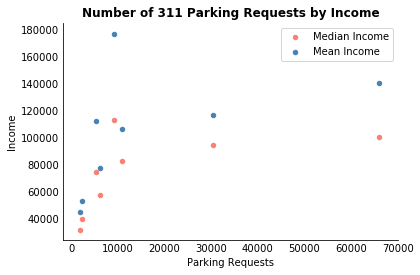

In [11]:
ax1 = req_income.plot(kind='scatter', x="Parking Requests", y="Median Income", color="salmon")    
ax2 = req_income.plot(kind='scatter', x="Parking Requests", y="Mean Income", color="steelblue", ax=ax1) 
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlim(right=70000)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title("Number of 311 Parking Requests by Income",fontweight="bold")
plt.legend(["Median Income","Mean Income"],loc="upper right")
plt.ylabel("Income")
plt.show()

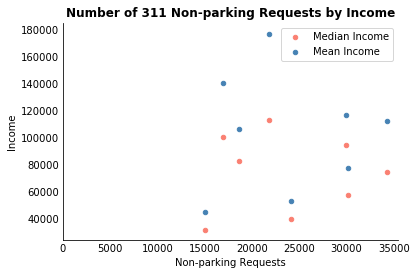

In [12]:
ax3 = req_income.plot(kind='scatter', x="Non-parking Requests", y="Median Income", color="salmon")    
ax4 = req_income.plot(kind='scatter', x="Non-parking Requests", y="Mean Income", color="steelblue", ax=ax3) 
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(left=0)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title("Number of 311 Non-parking Requests by Income",fontweight="bold")
plt.legend(["Median Income","Mean Income"],loc="upper right")
plt.ylabel("Income")
plt.show()

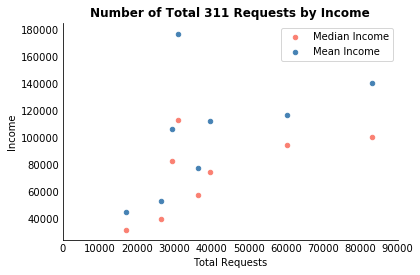

In [13]:
ax5 = req_income.plot(kind='scatter', x="Total Requests", y="Median Income", color="salmon")    
ax6 = req_income.plot(kind='scatter', x="Total Requests", y="Mean Income", color="steelblue", ax=ax5) 
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.set_xlim(left=0,right=90000)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.title("Number of Total 311 Requests by Income",fontweight="bold")
plt.legend(["Median Income","Mean Income"],loc="upper right")
plt.ylabel("Income")
plt.show()